In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 그래프 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 20, 10
plt.rcParams['axes.unicode_minus'] = False

import tensorflow as tf
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Embedding, LSTM, Activation, Conv1D, MaxPooling1D
from keras.datasets import mnist
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import LeakyReLU, BatchNormalization, Reshape, Input, UpSampling2D
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics

# VGG16 모델. (이미 학습이 완료되어 있는 이미지 인식 모델)
from keras.applications import VGG16

# GPU 사용 초기화 및 할당.
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# seed 값 설정.
np.random.seed(3)
tf.random.set_seed(3)

# < 학습용 데이터 준비 >
# 이미지를 읽을 떄 적용할 옵션 설정.
# rescale : 읽어온 이미지 데이터를 0 ~ 1 사이로 모두 변환.(스케일링)

## 굳이 설정 안해도 상관 없음.
# horizontal_flip : 세로를 기준으로 좌우를 똑같이 맞춤.
# width_shift_range : 전체 크기의 105 범위에서 좌우로 이동.
# height_shift_range : 전체 크기의 10% 번에서 위아래로 이동.
# fill_mode : 이미지 전체를 꽉 채울 형태.
train_datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=True, width_shift_range=0.1, 
                                   height_shift_range=0.1, fill_mode='nearest')

# 학습용 데이터 불러오기.
train_generator = train_datagen.flow_from_directory(
    'data/MRI/train',      # 데이터 경로.
    target_size=(150,150), # 읽어올 이미지 크기.
    batch_size=5,          # 한번에 읽어올 크기.
    class_mode='binary'    # 결과 데이터 형태.
)

# < 검증용 데이터 준비 >
test_datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=True, width_shift_range=0.1, 
                         height_shift_range=0.1, fill_mode='nearest')

# 검증용 데이터 불러오기.
test_generator = test_datagen.flow_from_directory(
    'data/MRI/test',      # 데이터 경로.
    target_size=(150,150), # 읽어올 이미지 크기.
    batch_size=5,          # 한번에 읽어올 크기.
    class_mode='binary'    # 결과 데이터 형태.
)

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [3]:
# 모델 설정.
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

In [4]:
# 모델 컴파일.
# 이미지 비교에 대한 손실 함수는 'sparse_categorical_crossentropy' 이걸로 사용.
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 저장 콜백.
model_path = 'models/{epoch}-{val_loss}.hdf5'

# 저장 조건.
callback1 = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=0, save_best_only=True)

# 조기중단 콜백.
callback2 = EarlyStopping(monitor='val_loss', patience=150)

# 학습.
history = model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=1000, 
          validation_data=test_generator, validation_steps=(len(test_generator)),  callbacks=[callback1, callback2])

Epoch 1/1000
32/32 [==============================] - 3s 45ms/step - loss: 0.7294 - accuracy: 0.5127 - val_loss: 0.6910 - val_accuracy: 0.5000
Epoch 2/1000
32/32 [==============================] - 1s 38ms/step - loss: 0.6926 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.4250
Epoch 3/1000
32/32 [==============================] - 1s 38ms/step - loss: 0.6965 - accuracy: 0.5523 - val_loss: 0.6908 - val_accuracy: 0.5750
Epoch 4/1000
32/32 [==============================] - 1s 37ms/step - loss: 0.6885 - accuracy: 0.5608 - val_loss: 0.6874 - val_accuracy: 0.5083
Epoch 5/1000
32/32 [==============================] - 1s 38ms/step - loss: 0.6943 - accuracy: 0.4983 - val_loss: 0.7683 - val_accuracy: 0.5000
Epoch 6/1000
32/32 [==============================] - 1s 39ms/step - loss: 0.7521 - accuracy: 0.5085 - val_loss: 0.6928 - val_accuracy: 0.5083
Epoch 7/1000
32/32 [==============================] - 1s 37ms/step - loss: 0.6968 - accuracy: 0.5122 - val_loss: 0.6895 - val_accuracy: 0.6750

32/32 [==============================] - 1s 37ms/step - loss: 0.1058 - accuracy: 0.9767 - val_loss: 0.0675 - val_accuracy: 0.9750
Epoch 58/1000
32/32 [==============================] - 1s 38ms/step - loss: 0.0904 - accuracy: 0.9813 - val_loss: 0.1822 - val_accuracy: 0.9333
Epoch 59/1000
32/32 [==============================] - 1s 41ms/step - loss: 0.0447 - accuracy: 0.9844 - val_loss: 0.1193 - val_accuracy: 0.9417
Epoch 60/1000
32/32 [==============================] - 1s 37ms/step - loss: 0.0449 - accuracy: 0.9793 - val_loss: 0.0438 - val_accuracy: 0.9750
Epoch 61/1000
32/32 [==============================] - 1s 40ms/step - loss: 0.0481 - accuracy: 0.9754 - val_loss: 0.0652 - val_accuracy: 0.9667
Epoch 62/1000
32/32 [==============================] - 1s 39ms/step - loss: 0.0573 - accuracy: 0.9800 - val_loss: 0.0914 - val_accuracy: 0.9667
Epoch 63/1000
32/32 [==============================] - 1s 39ms/step - loss: 0.0428 - accuracy: 0.9939 - val_loss: 0.1841 - val_accuracy: 0.9500
Epoch 

32/32 [==============================] - 1s 36ms/step - loss: 0.0193 - accuracy: 0.9964 - val_loss: 0.1791 - val_accuracy: 0.9583
Epoch 114/1000
32/32 [==============================] - 1s 36ms/step - loss: 0.0351 - accuracy: 0.9833 - val_loss: 0.1691 - val_accuracy: 0.9500
Epoch 115/1000
32/32 [==============================] - 1s 37ms/step - loss: 0.0322 - accuracy: 0.9842 - val_loss: 0.0763 - val_accuracy: 0.9667
Epoch 116/1000
32/32 [==============================] - 1s 36ms/step - loss: 0.0141 - accuracy: 0.9983 - val_loss: 0.0981 - val_accuracy: 0.9667
Epoch 117/1000
32/32 [==============================] - 1s 37ms/step - loss: 0.0946 - accuracy: 0.9496 - val_loss: 0.1216 - val_accuracy: 0.9500
Epoch 118/1000
32/32 [==============================] - 1s 36ms/step - loss: 0.0729 - accuracy: 0.9781 - val_loss: 0.1317 - val_accuracy: 0.9583
Epoch 119/1000
32/32 [==============================] - 1s 36ms/step - loss: 0.0487 - accuracy: 0.9753 - val_loss: 0.0401 - val_accuracy: 0.9917


32/32 [==============================] - 1s 38ms/step - loss: 0.0068 - accuracy: 0.9981 - val_loss: 0.0964 - val_accuracy: 0.9750
Epoch 170/1000
32/32 [==============================] - 1s 37ms/step - loss: 0.0159 - accuracy: 0.9897 - val_loss: 0.0608 - val_accuracy: 0.9750
Epoch 171/1000
32/32 [==============================] - 1s 37ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.0729 - val_accuracy: 0.9667
Epoch 172/1000
32/32 [==============================] - 1s 37ms/step - loss: 0.0141 - accuracy: 0.9930 - val_loss: 0.1799 - val_accuracy: 0.9583
Epoch 173/1000
32/32 [==============================] - 1s 37ms/step - loss: 0.0587 - accuracy: 0.9591 - val_loss: 0.1183 - val_accuracy: 0.9333
Epoch 174/1000
32/32 [==============================] - 1s 37ms/step - loss: 0.0307 - accuracy: 0.9835 - val_loss: 0.0158 - val_accuracy: 0.9917
Epoch 175/1000
32/32 [==============================] - 1s 37ms/step - loss: 0.1400 - accuracy: 0.9576 - val_loss: 0.0686 - val_accuracy: 0.9833


32/32 [==============================] - 1s 37ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.1301 - val_accuracy: 0.9750
Epoch 226/1000
32/32 [==============================] - 1s 36ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1550 - val_accuracy: 0.9667
Epoch 227/1000
32/32 [==============================] - 1s 37ms/step - loss: 0.0222 - accuracy: 0.9829 - val_loss: 0.0646 - val_accuracy: 0.9750
Epoch 228/1000
32/32 [==============================] - 1s 38ms/step - loss: 0.0104 - accuracy: 0.9986 - val_loss: 0.1367 - val_accuracy: 0.9750
Epoch 229/1000
32/32 [==============================] - 1s 37ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.1223 - val_accuracy: 0.9583
Epoch 230/1000
32/32 [==============================] - 1s 38ms/step - loss: 7.0757e-04 - accuracy: 1.0000 - val_loss: 0.1085 - val_accuracy: 0.9750
Epoch 231/1000
32/32 [==============================] - 1s 37ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.1309 - val_accuracy: 0.9

32/32 [==============================] - 1s 38ms/step - loss: 0.0265 - accuracy: 0.9915 - val_loss: 0.2454 - val_accuracy: 0.9500
Epoch 281/1000
32/32 [==============================] - 1s 39ms/step - loss: 6.7459e-04 - accuracy: 1.0000 - val_loss: 0.0625 - val_accuracy: 0.9833A: 0s - loss: 7.9527e-04 - accuracy
Epoch 282/1000
32/32 [==============================] - 1s 39ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.1457 - val_accuracy: 0.9667
Epoch 283/1000
32/32 [==============================] - 1s 37ms/step - loss: 0.0022 - accuracy: 0.9996 - val_loss: 0.1755 - val_accuracy: 0.9583
Epoch 284/1000
32/32 [==============================] - 1s 37ms/step - loss: 0.0064 - accuracy: 0.9957 - val_loss: 0.5399 - val_accuracy: 0.9417
Epoch 285/1000
32/32 [==============================] - 1s 38ms/step - loss: 0.0296 - accuracy: 0.9935 - val_loss: 0.1652 - val_accuracy: 0.9417
Epoch 286/1000
32/32 [==============================] - 1s 36ms/step - loss: 0.0296 - accuracy: 0.9913 - v

32/32 [==============================] - 1s 37ms/step - loss: 0.0297 - accuracy: 0.9863 - val_loss: 0.1238 - val_accuracy: 0.9750
Epoch 337/1000
32/32 [==============================] - 1s 37ms/step - loss: 0.0111 - accuracy: 0.9930 - val_loss: 0.1196 - val_accuracy: 0.9833
Epoch 338/1000
32/32 [==============================] - 1s 38ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.1468 - val_accuracy: 0.9750
Epoch 339/1000
32/32 [==============================] - 1s 38ms/step - loss: 3.4010e-04 - accuracy: 1.0000 - val_loss: 0.1000 - val_accuracy: 0.9833
Epoch 340/1000
32/32 [==============================] - 1s 38ms/step - loss: 6.2316e-04 - accuracy: 1.0000 - val_loss: 0.1389 - val_accuracy: 0.9833
Epoch 341/1000
32/32 [==============================] - 1s 37ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1195 - val_accuracy: 0.9833
Epoch 342/1000
32/32 [==============================] - 1s 38ms/step - loss: 2.1776e-05 - accuracy: 1.0000 - val_loss: 0.0429 - val_accur

Epoch 392/1000
32/32 [==============================] - 1s 36ms/step - loss: 0.0069 - accuracy: 0.9957 - val_loss: 0.1424 - val_accuracy: 0.9750
Epoch 393/1000
32/32 [==============================] - 1s 36ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0822 - val_accuracy: 0.9917
Epoch 394/1000
32/32 [==============================] - 1s 36ms/step - loss: 0.0096 - accuracy: 0.9901 - val_loss: 0.1423 - val_accuracy: 0.9750
Epoch 395/1000
32/32 [==============================] - 1s 36ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0551 - val_accuracy: 0.9833
Epoch 396/1000
32/32 [==============================] - 1s 36ms/step - loss: 7.4774e-04 - accuracy: 1.0000 - val_loss: 0.1334 - val_accuracy: 0.9833
Epoch 397/1000
32/32 [==============================] - 1s 36ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.1713 - val_accuracy: 0.9833
Epoch 398/1000
32/32 [==============================] - 1s 41ms/step - loss: 0.0431 - accuracy: 0.9752 - val_loss: 0.2243 - va

In [6]:
# 최적 모형 불러오기.
best_model = load_model('models/288-0.0034864279441535473.hdf5')
best_model.evaluate(test_generator)[1]

24/24 [==============================] - 1s 19ms/step - loss: 0.0441 - accuracy: 0.9833


0.9833333492279053

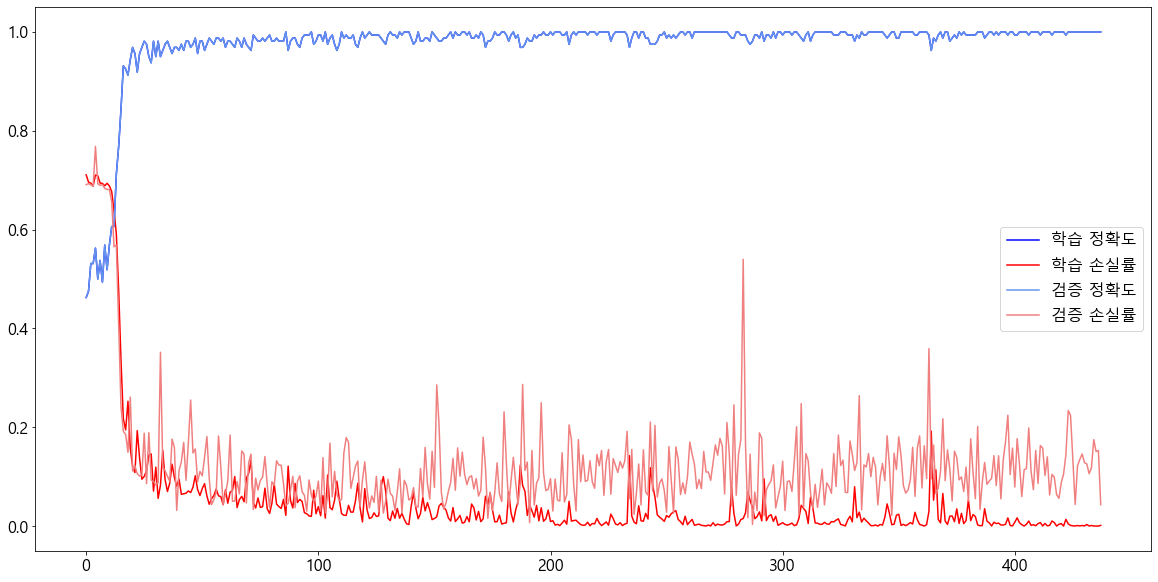

In [18]:
# 학습 데이터 정확도와 오차.
acc = history.history['accuracy']
y_loss = history.history['loss']

# 검증 데이터 정확도와 오차.
y_vloss = history.history['val_loss']
val_acc = history.history['accuracy']

# 그래프.
x_len = np.arange(len(y_loss))

plt.plot(x_len, acc, marker='', c='blue', label='학습 정확도' )
plt.plot(x_len, y_loss, marker='', c='red', label='학습 손실률' )
plt.plot(x_len, val_acc, marker='', c='cornflowerblue', label='검증 정확도' )
plt.plot(x_len, y_vloss, marker='', c='lightcoral', label='검증 손실률' )
plt.legend()
plt.show()

In [11]:
# VGG16 모델 불러오기.
model1 = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

# 학습 방지.
model1.trainable = False
model1.summary()

58892288/58889256 [==============================] - 8s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [13]:
# 모델2 설정.
model2 =Sequential()
model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dense(2, activation='softmax'))

In [14]:
# 모델2 컴파일.
# 이미지 비교에 대한 손실 함수는 'sparse_categorical_crossentropy' 이걸로 사용.
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습.
history2 = model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=100, 
          validation_data=test_generator, validation_steps=(len(test_generator)),  callbacks=[callback1, callback2])

Epoch 1/100
32/32 [==============================] - 1s 37ms/step - loss: 0.1187 - accuracy: 0.9750 - val_loss: 0.0257 - val_accuracy: 0.9833
Epoch 2/100
32/32 [==============================] - 1s 35ms/step - loss: 0.0411 - accuracy: 0.9875 - val_loss: 0.0156 - val_accuracy: 0.9833
Epoch 3/100
32/32 [==============================] - 1s 36ms/step - loss: 0.0381 - accuracy: 0.9875 - val_loss: 0.2475 - val_accuracy: 0.9667
Epoch 4/100
32/32 [==============================] - 1s 36ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0744 - val_accuracy: 0.9750
Epoch 5/100
32/32 [==============================] - 1s 38ms/step - loss: 0.0124 - accuracy: 0.9937 - val_loss: 0.2585 - val_accuracy: 0.9667
Epoch 6/100
32/32 [==============================] - 1s 37ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.3103 - val_accuracy: 0.9583
Epoch 7/100
32/32 [==============================] - 1s 36ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.1193 - val_accuracy: 0.9750
Epoch 

32/32 [==============================] - 1s 38ms/step - loss: 2.0754e-04 - accuracy: 1.0000 - val_loss: 0.1763 - val_accuracy: 0.9750
Epoch 58/100
32/32 [==============================] - 1s 39ms/step - loss: 8.7243e-04 - accuracy: 1.0000 - val_loss: 0.1912 - val_accuracy: 0.9667
Epoch 59/100
32/32 [==============================] - 1s 39ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.1212 - val_accuracy: 0.9917
Epoch 60/100
32/32 [==============================] - 1s 39ms/step - loss: 2.2161e-04 - accuracy: 1.0000 - val_loss: 0.1371 - val_accuracy: 0.9833
Epoch 61/100
32/32 [==============================] - 1s 39ms/step - loss: 0.0054 - accuracy: 0.9937 - val_loss: 0.1666 - val_accuracy: 0.9750
Epoch 62/100
32/32 [==============================] - 1s 37ms/step - loss: 4.3674e-04 - accuracy: 1.0000 - val_loss: 0.1970 - val_accuracy: 0.9750
Epoch 63/100
32/32 [==============================] - 1s 37ms/step - loss: 9.6390e-04 - accuracy: 1.0000 - val_loss: 0.1356 - val_accuracy:

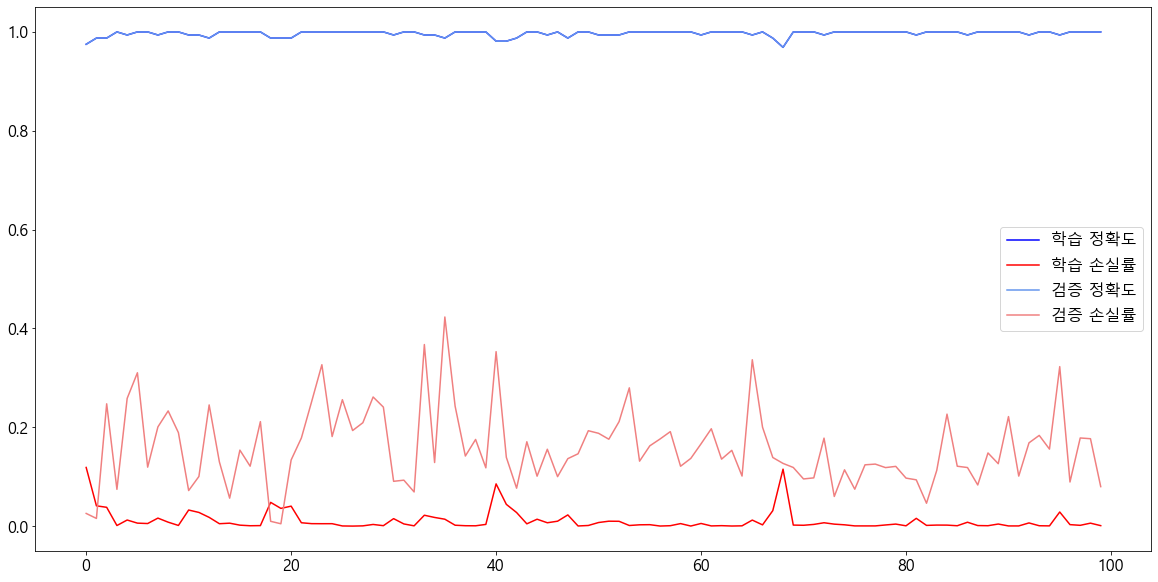

In [17]:
# 학습 데이터 정확도와 오차.
acc2 = history2.history['accuracy']
y_loss2 = history2.history['loss']

# 검증 데이터 정확도와 오차.
y_vloss2 = history2.history['val_loss']
val_acc2 = history2.history['accuracy']

# 그래프.
x_len = np.arange(len(y_loss2))

plt.plot(x_len, acc2, marker='', c='blue', label='학습 정확도' )
plt.plot(x_len, y_loss2, marker='', c='red', label='학습 손실률' )
plt.plot(x_len, val_acc2, marker='', c='cornflowerblue', label='검증 정확도' )
plt.plot(x_len, y_vloss2, marker='', c='lightcoral', label='검증 손실률' )
plt.legend()
plt.show()